In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import PIL
from scipy import ndimage
import os

In [2]:
annotations_df = pd.read_csv('C:/Users/XY/Desktop/yolov3/data/train_subset_df.csv', header=0)

In [3]:
annotations_df.head()

,data_directory,file_name,image_width,image_height,image_id,image_area,image_bbox,image_point_xy,image_segmentation,is_crowded,...,name,ind,new_id,file_path,x1,y1,x2,y2,yolo_bbox,yolo_annotation
0,data/images/train2019/,038900004095_camera0-13.jpg,2592,1944,0,111763.29,"[1188.4, 1052.45, 390.96, 285.87]","[1383.88, 1195.38]",[[]],0,...,都乐菠萝块234g,111,111,data/images/train2019/038900004095_camera0-13.jpg,1188,1052,1579,1338,"[0.5339043209876544, 0.6149099794238684, 0.150...","[111, 0.5339043209876544, 0.6149099794238684, ..."
1,data/images/train2019/,038900004095_camera0-18.jpg,2592,1944,1,110516.13,"[1214.89, 1053.72, 392.36, 281.67]","[1411.07, 1194.56]",[[]],0,...,都乐菠萝块234g,111,111,data/images/train2019/038900004095_camera0-18.jpg,1214,1053,1607,1335,"[0.5443942901234569, 0.6144830246913581, 0.151...","[111, 0.5443942901234569, 0.6144830246913581, ..."
2,data/images/train2019/,038900004095_camera0-11.jpg,2592,1944,2,108233.00,"[1180.52, 1055.31, 384.33, 281.62]","[1372.68, 1196.12]",[[]],0,...,都乐菠萝块234g,111,111,data/images/train2019/038900004095_camera0-11.jpg,1180,1055,1564,1336,"[0.529585262345679, 0.6152880658436214, 0.1482...","[111, 0.529585262345679, 0.6152880658436214, 0..."
3,data/images/train2019/,038900004095_camera0-10.jpg,2592,1944,3,113598.14,"[1171.68, 1047.6, 399.85, 284.1]","[1371.61, 1189.65]",[[]],0,...,都乐菠萝块234g,111,111,data/images/train2019/038900004095_camera0-10.jpg,1171,1047,1571,1331,"[0.5291685956790123, 0.6119598765432098, 0.154...","[111, 0.5291685956790123, 0.6119598765432098, ..."
4,data/images/train2019/,038900004095_camera0-17.jpg,2592,1944,4,115162.14,"[1197.98, 1052.86, 413.0, 278.84]","[1404.48, 1192.28]",[[]],0,...,都乐菠萝块234g,111,111,data/images/train2019/038900004095_camera0-17.jpg,1197,1052,1610,1331,"[0.5418518518518518, 0.6133127572016459, 0.159...","[111, 0.5418518518518518, 0.6133127572016459, ..."


In [122]:
# img_file_name = '6928804011456_camera3-3.jpg'
img_file_name = '6924513908155_camera1-32.jpg'
img = cv2.imread(os.path.join('C:/Users/XY/Desktop/yolov3/data/images/train2019/', img_file_name))

In [69]:
cv2.imshow('Image',img) 
cv2.waitKey(0)
cv2.destroyAllWindows()

In [91]:
bbox = eval(annotations_df[annotations_df['file_name']==img_file_name]['image_bbox'].values[0]) #[1184.83, 347.87, 331.45, 1162.72]
x, y, w, h = [int(x) for x in bbox]
origin_height, origin_width = img.shape[:2]

In [92]:
box_pad = 5
crop_x1 = x - box_pad
crop_y1 = y - box_pad
crop_x2 = x + w + box_pad
crop_y2 = y + h + box_pad

x = x - crop_x1
y = y - crop_y1

origin_img = img = img[crop_y1:crop_y2, crop_x1:crop_x2]

img = cv2.bilateralFilter(img, 3, 75, 75)

In [155]:
cv2.imshow('Image',img) 
cv2.waitKey(0)
cv2.destroyAllWindows()

In [118]:
# img2 = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# img2 = cv2.adaptiveThreshold(img2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,11,2)
# img2 = cv2.bitwise_not(img2)
# img3 = cv2.cvtColor(img2,cv2.COLOR_GRAY2RGB)
# img3 = cv2.erode(img3, np.ones((1, 1), np.uint8))

detector = cv2.ximgproc.createStructuredEdgeDetection('model.yml')
edges = detector.detectEdges(np.float32(img) / 255)

# -------------------------
# edge process
# -------------------------
object_box_mask = np.zeros_like(edges, dtype=np.uint8)
object_box_mask[y:y + h, x:x + w] = 1
edges[(1 - object_box_mask) == 1] = 0
edges[(edges < (edges.mean() * 0.5)) & (edges < 0.1)] = 0

# -------------------------
# erode and dilate
# -------------------------
filled = ndimage.binary_fill_holes(edges).astype(np.uint8)
filled = cv2.erode(filled, np.ones((32, 32), np.uint8))
filled = cv2.dilate(filled, np.ones((32, 32), np.uint8))
filled = cv2.erode(filled, np.ones((8, 8), np.uint8))
filled = ndimage.binary_fill_holes(filled).astype(np.uint8)

filled = cv2.medianBlur(filled, 17)
save_image = np.zeros((origin_height, origin_width), np.uint8)
save_image[crop_y1:crop_y2, crop_x1:crop_x2] = np.array(filled * 255, dtype=np.uint8)

masked_img = origin_img * filled[:, :, None]
compare_img = np.concatenate([origin_img, masked_img], axis=1)

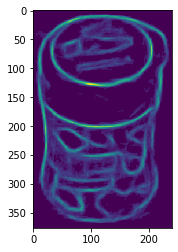

In [119]:
plt.imshow(edges)

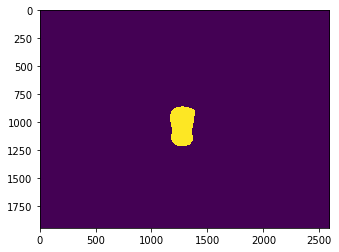

In [120]:
plt.imshow(save_image)

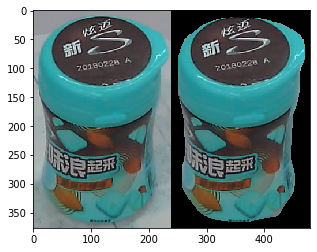

In [121]:
plt.imshow(compare_img)

In [79]:
def do_extract(path):
    annotation = annotations[os.path.basename(path)]
    bbox = annotation['bbox']
    x, y, w, h = [int(x) for x in bbox]
    img = cv2.imread(path)
    origin_height, origin_width = img.shape[:2]

    box_pad = 5
    crop_x1 = x - box_pad
    crop_y1 = y - box_pad
    crop_x2 = x + w + box_pad
    crop_y2 = y + h + box_pad

    x = x - crop_x1
    y = y - crop_y1

    origin_img = img = img[crop_y1:crop_y2, crop_x1:crop_x2]

    img = cv2.bilateralFilter(img, 3, 75, 75)

    # -------------------------
    # edge detect
    # -------------------------
    edges = detector.detectEdges(np.float32(img) / 255)

    # -------------------------
    # edge process
    # -------------------------
    object_box_mask = np.zeros_like(edges, dtype=np.uint8)
    object_box_mask[y:y + h, x:x + w] = 1
    edges[(1 - object_box_mask) == 1] = 0
    edges[(edges < (edges.mean() * 0.5)) & (edges < 0.1)] = 0

    # -------------------------
    # erode and dilate
    # -------------------------
    filled = ndimage.binary_fill_holes(edges).astype(np.uint8)
    filled = cv2.erode(filled, np.ones((32, 32), np.uint8))
    filled = cv2.dilate(filled, np.ones((32, 32), np.uint8))
    filled = cv2.erode(filled, np.ones((8, 8), np.uint8))

    filled = cv2.medianBlur(filled, 17)
    save_image = np.zeros((origin_height, origin_width), np.uint8)
    save_image[crop_y1:crop_y2, crop_x1:crop_x2] = np.array(filled * 255, dtype=np.uint8)
    cv2.imwrite(os.path.join(output_dir, os.path.basename(path).split('.')[0] + '.png'), save_image)

    masked_img = origin_img * filled[:, :, None]
    compare_img = np.concatenate([origin_img, masked_img], axis=1)
    cv2.imwrite(os.path.join(compare_dir, os.path.basename(path)), compare_img)